# Introduction

PyTorch - одно из самых популярных решений для глубокого обучения, вокруг которого построены обсуждаемые инструменты.

Одна из общераспространенных практик его использования - конструировать и обучать модели на PyTorch, а при переходе в прод, для инференса
конвертировать их в другие форматы, например в ONNX, и использовать далее за пределами PyTorch.

Как правило, процесс обучения моделей не сильно отличается от модели к модели, из кода в код кочуют так называемые `boiler plates` - части функционала, которые не меняются от обучения к обучению. Яркие примеры:

- указание девайсов 
- вычисление градиента
- градиентный шаг
- очистка градиента

Что касается общих структур, как правило, всем нужно одно и то же:

- настройка оптимайзеров и параметров обучения
- логирование лосов и метрик
- перевод моделей в другие форматы

Естественно какие-то конкретные вещи могут меняться от обучения к обучению и всегда есть необходимость внесения своих правок в процесс обучения. PyTorch Lightning - это фреймворк для обучения, настройки и деплоя моделей глубокого обучения. Фреймворк состоит из трех основных пакетов:

- PyTorch Lightning: Train and deploy PyTorch at scale.
- Lightning Fabric: Expert control.
- Lightning Apps: Build AI products and ML workflows.

Фреймворк дает детальный контроль уровня необходимых абстракций над PyTorch'ом. Он позволяет инкапсулировать boiler plate части кода, при этом сохраняя возможность гибкой настройки отдельных элементов при необходимости:

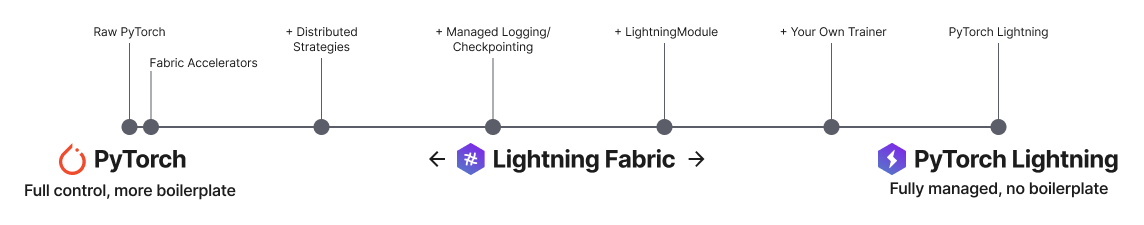

PyTorch Lightning является частью коллекции инструментов Lightning AI, в
которую входят:

- Pytorch Lightning - Pretrain, finetune and deploy AI models on multiple GPUs, TPUs with zero code changes.
- Torchmetrics - Machine learning metrics for distributed, scalable PyTorch applications.
- Lit-LLama - Implementation of the LLaMA language model based on nanoGPT.
- Lit-GPT - Hackable implementation of state-of-the-art open-source LLMs based on nanoGPT.

Полезные ссылки:

- [Lightning AI](https://lightning.ai/)
- [PyTorch Lightning Website](https://lightning.ai/pytorch-lightning/)
- [Lightning GitHub](https://github.com/Lightning-AI/lightning#pytorch-lightning-train-and-deploy-pytorch-at-scale)
- [Lightning in 15 minutes](https://lightning.ai/docs/pytorch/stable/starter/introduction.html)
- [Lightning Docs](https://lightning.ai/docs/pytorch/stable/)

# 1. PyTorch Lightning

### Installation

```Bash
pip install lightning
```

### MNIST Example. PyTorch

In [15]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision as tv

import matplotlib.pyplot as plt

Dataset:

In [16]:
dataset = tv.datasets.MNIST(".", download=True, transform=tv.transforms.ToTensor())
mnist_train, mnist_val = data.random_split(dataset, [55000, 5000])

mnist_train_dl = data.DataLoader(mnist_train, batch_size=16)
mnist_val_dl = data.DataLoader(mnist_val, batch_size=16)

Model:

In [17]:
class PyTorchAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))
        self.decoder = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [18]:
pytorch_autoencoder = PyTorchAutoEncoder()

Optimizer:

In [19]:
optimizer = torch.optim.Adam(pytorch_autoencoder.parameters(), lr=1e-3)

Train Loop:

In [20]:
EPOCHS = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

pytorch_autoencoder.to(device)
pytorch_autoencoder.train()

batch_losses = []

for epoch in range(EPOCHS):
    for train_batch in mnist_train_dl:
        x, y = train_batch
        x = x.to(device)
        x = x.view(x.size(0), -1)

        z = pytorch_autoencoder.encoder(x)
        x_hat = pytorch_autoencoder.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        batch_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

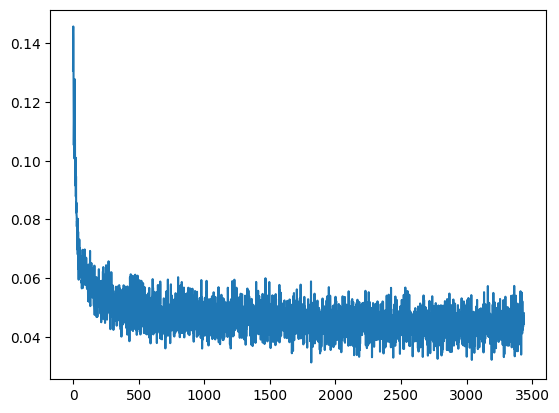

In [21]:
plt.plot(batch_losses);

Eval Loop:

In [22]:
pytorch_autoencoder.eval()
with torch.no_grad():
    val_loss = []
    for val_batch in mnist_val_dl:
        x, y = val_batch
        x = x.to(device)
        x = x.view(x.size(0), -1)
        z = pytorch_autoencoder.encoder(x)
        x_hat = pytorch_autoencoder.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        val_loss.append(loss)
    val_loss = torch.mean(torch.tensor(val_loss))
    print(f'val_loss: {round(val_loss.item(), 3)}')
    pytorch_autoencoder.train()

val_loss: 0.044


### MNIST Example. Lightning

In [23]:
import lightning as L

Dataset:

In [24]:
# --//--

Model:

In [30]:
class LitAutoEncoder(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 128), nn.ReLU(), nn.Linear(128, 3))
        self.decoder = nn.Sequential(nn.Linear(3, 128), nn.ReLU(), nn.Linear(128, 28 * 28))

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def validation_step(self, batch, batch_idx):
        # To add a validation loop, implement the validation_step method of the LightningModule
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        val_loss = nn.functional.mse_loss(x_hat, x)
        self.log("val_loss", val_loss)

Train:

In [34]:
lit_autoencoder = LitAutoEncoder()
trainer = L.Trainer(max_epochs=3)
trainer.fit(lit_autoencoder, mnist_train_dl, mnist_val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 100 K 
1 | decoder | Sequential | 101 K 
---------------------------------------
202 K     Trainable params
0         Non-trainable params
202 K     Total params
0.810     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=3` reached.


Visualize the Training Process:

In [35]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [59]:
# Lightning trainer will create `lightning_logs` dir automaticly
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 41858), started 1:22:02 ago. (Use '!kill 41858' to kill it.)

Model Evaluation:

In [37]:
trainer.validate(model=lit_autoencoder, dataloaders=mnist_val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                                                                                 …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.03822116553783417
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.03822116553783417}]

Use the Model:

In [6]:
!ls lightning_logs/version_4/checkpoints

'epoch=0-step=3438.ckpt'


In [58]:
# manual checkpoint saving
trainer.save_checkpoint('./lightning_logs/version_4/checkpoints/custom_save.ckpt')

In [7]:
checkpoint = "./lightning_logs/version_4/checkpoints/epoch=0-step=3438.ckpt"
autoencoder = LitAutoEncoder.load_from_checkpoint(checkpoint)

In [8]:
encoder = autoencoder.encoder
encoder.eval()

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=3, bias=True)
)

In [9]:
fake_image_batch = torch.Tensor(4, 28 * 28).to('cuda')
with torch.no_grad():
    embeddings = encoder(fake_image_batch)

In [10]:
embeddings

tensor([[ 2.5665e+16,  3.9260e+17,  3.3382e+17],
        [ 1.5007e+21,  1.4023e+21,  4.9495e+20],
        [-2.3673e+15, -1.6974e+15,  3.5760e+15],
        [ 2.0875e-01,  2.3807e-02,  7.0597e-02]], device='cuda:0')

Export the model in ONNX:

In [11]:
input_sample = torch.randn((1, 28 * 28))
autoencoder.to_onnx('./autoencoder.onnx', input_sample, export_params=True)

In [47]:
import numpy as np
import onnxruntime

In [48]:
ort_session = onnxruntime.InferenceSession('./autoencoder.onnx')

In [56]:
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: np.random.randn(1, 28 * 28).astype(np.float32)}
ort_outs = ort_session.run(None, ort_inputs)

In [57]:
ort_outs

[array([[-0.3540863 ,  0.22646873,  1.9857447 ]], dtype=float32)]

### Lightning Trainer

[Lightning Trainer Docs](https://lightning.ai/docs/pytorch/stable/common/trainer.html)

Что происходит под капотом `Trainer`:

- автоматическое включение / отключение градиентов
- вычисления на тренировочном, валидационном и тестовом даталоадерах
- вызов callbacks в нужное время
- распределение батчей и вычислений по корректным девайсам

Trainer имеет 35 флагов, отвечающих за различные настройки процесса обучения. Интересные:

- callbacks
- fast_dev_run
- gradient_clip
- max_time
- precision

# 2. PyTorch Lightning Fabric

Модуль `Fabric` позволяет быстро расширять чистый PyTorch код до возможности использования продвинутых инструментов, подобных `Lightning Trainer`, например:

- обучение на нескольких девайсах
- распределенное обучение
- те же технические мелочи на подобии `.to`, `optimizer.step()`, ...

Here are 4 easy steps to use Fabric in your PyTorch code.

1. Create the Lightning Fabric object at the beginning of your script.

2. Remove all ``.to`` and ``.cuda`` calls since Fabric will take care of it.

3. Apply ``setup`` over each model and optimizers pair, ``setup_dataloaders`` on all your dataloaders,
and replace ``loss.backward()`` with ``self.backward(loss)``.

4. Run the script from the terminal using ``lightning run model path/to/train.py``

Accelerate your training loop by setting the ``--accelerator``, ``--strategy``, ``--devices`` options directly from
the command line. See ``lightning run model --help`` or learn more from the [documentation](https://lightning.ai/docs/fabric).

Пример изменений в коде:

```Python
import torch
  from lightning.pytorch.demos import WikiText2, Transformer
  import lightning as L                                                  # +

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # -
  fabric = L.Fabric(accelerator="cuda", devices=8, strategy="ddp")       # +
  fabric.launch()                                                        # +

  dataset = WikiText2()
  dataloader = torch.utils.data.DataLoader(dataset)
  model = Transformer(vocab_size=dataset.vocab_size)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

  model = model.to(device)                                               # -
  model, optimizer = fabric.setup(model, optimizer)                      # +
  dataloader = fabric.setup_dataloaders(dataloader)                      # +

  model.train()
  for epoch in range(20):
      for batch in dataloader:
          input, target = batch
          input, target = input.to(device), target.to(device)            # -
          optimizer.zero_grad()
          output = model(input, target)
          loss = torch.nn.functional.nll_loss(output, target.view(-1))
          loss.backward()                                                # -
          fabric.backward(loss)                                          # +
          optimizer.step()
```

[More Examples](https://lightning.ai/docs/fabric/stable/examples/).

# 3. Lightning Apps

Модуль `Lightning Apps` позволяет избавиться от cloud infrastructure boilerplate, что позволяет сфокусироваться на решении исследовательских или бизнес задач. `Lightning Apps` может быть запущен на:

- `Lightning Cloud`
- собственном кластере
- в приватном облаке

Документация:
- [Lightning Apps Docs](https://lightning.ai/docs/app/stable/)
- [Serving Scikit Learni Models](https://mlserver.readthedocs.io/en/latest/examples/sklearn/README.html)
- [Locust](https://locust.io/)